In [2]:
import sys
#/Users/aidanmcclung/Desktop/Summer_Exoplanets #The path to my QAOP Module
sys.path.append('/Users/aidanmcclung/Desktop/Summer_Exoplanets') #Enable QAOP module

import numpy as np
#import astropy.units as u
#from astropy.io import fits
#from astropy.wcs import WCS
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style


from QAOP.QAOP_utils import * #import getTimeFromDate in particular.

#plt.style.use(astropy_mpl_style)
#plt.rcParams['figure.figsize'] = [10,8]

#import warnings; warnings.filterwarnings('ignore') #Disbale FITS format warnings - not needed here.

prop_cycle = plt.rcParams['axes.prop_cycle']
def_colors = prop_cycle.by_key()['color']
#print(def_colors) #['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'
#def_colors_lightened = ['#99cbed','#ffcc9f','#9fe59f','#efa8a8','#d4c2e5','#d6b8b2','#f4c9e7','#cccccc','#eded9e','#9aecf4']
#def_colors_darkened = ['#16537e','#bc5800','#1f701f','#961b1c','#683e8e','#623c34','#c92998','#595959','#848418','#108591']

import io
def print_to_string(*args, **kwargs):
    output = io.StringIO()
    print(*args, file=output, **kwargs)
    contents = output.getvalue()
    output.close()
    return contents

In [28]:
def convertJD(timeJD,refTimeJD=0):
    diff = timeJD - refTimeJD
    days = diff // 1; remain = diff - days
    hours = remain // (1/24); remain -= (hours/24)
    minutes = remain // (1/(24*60)); remain -= (minutes/(24*60))
    seconds = remain*(24*60*60)
    print(timeJD,'days is',hours,"hours",minutes,'minutes and',seconds,'seconds')
    return {'h':hours,'m':minutes,'s':seconds}

In [22]:
def plotRefLines(t=13+(17/60),d=0.98,uncerr=(6/60),calls=0,label=False): 
    #uncertanity is for the centre, so it propogates to twice on either end
    #calls is the number of times it has been used in a plot, to set the colors
    if(label):
        plt.axvline(t-(d/2),alpha=0.1,lw=60*uncerr*2,color=def_colors[calls],label=label)
    else:
        plt.axvline(t-(d/2),alpha=0.1,lw=60*uncerr*2,color=def_colors[calls])
    plt.axvline(t+(d/2),alpha=0.1,lw=60*uncerr*2,color=def_colors[calls])
    plt.axvline(t-(d/2),alpha=1,lw=uncerr*2,color=def_colors[calls])
    plt.axvline(t+(d/2),alpha=1,lw=uncerr*2,color=def_colors[calls])
    
def plotRefLinesForSource(source,calls=0,label=False):
    t = source['midTime']
    d = source['d']
    uncerrT = source['mid_u']
    uncerrD = source['d_u']
    uncerr = (uncerrT**2 + uncerrD**2)**(1/2)
    plotRefLines(t=t,d=d,uncerr=uncerr,calls=calls,label=label)

## Description for use and Thoughts on this code

The hardest part of this whole process that I've set up for myself is the modifications I need to make in order for it to work right.

The first thing that has to be changed is the functions that are calculating time. Each one has daynumber, either `ourDay` or `refTimeJD`, with the additional ref parameters in the second case. These need to be updated, and when I made this code I was not thinking that it would be reused, but then I ended up needing it again. 

For the first function; it is calculating when the midpoint of the next transit would be by adding up periods since the published values; the centre of the transit (`Tc`). It also propogates the 'worst case' error by assuming we were maximally off on every parameter. In order to work right, `ourDay` should be a Julian Day Number that exists in between the transit we tried to observe, and the transit that would have come before it. In most cases I just use the day number before my observations (by subtracting one), but if the period is small enough you may need to move back fractional days instead. If you were to use the day (and time via decimal points) you had observed, you would be gambling on whether your source would have predicted the transit you care about before or after the time it occurred. In the former case, you would get back a result for the next transit, which would not be ideal.


The second function is just something that takes in a Julian Day Number, and gives back a datetime string that's in the same format as those that come from our fits files from iTelescope. Thus, you can convert it back into whatever form you need using the functions contained in the `QAOP_utils` module. It does a bit of an inefficient caluclation where it snips off bits comparing to a refernce time, and I certainly did not cover every edge case when coding it, so I usually find it's best practice to change the reference dates to something close to the observations.


The most painful part of the whole process though is putting in the sources. As it is, the only way to do so is to type in the values yourself, which is... relatively easy to copy and paste from the archive, but also not automated so... Basically, what you have to do is change the source names, and their values in the dictionary to be the ones you want, and then also make sure to change any references to the objects elsewhere in the code you're using as well.

In [63]:
def calculateMidpointJD(Tc,P,Tc_u=0,P_u=0,ourDay=2460163):
    #ourDay should be before the transit we want, because it will find the next one after that date
    
    #so we have a center point, and then we're going to add some number of periods to it.
    #we can know the number by subtracting our time from the Tc time in days.
    elapsedTime = ourDay-Tc
    numOrbits = elapsedTime/P #how many orbits, including the progress through latest one, have happened since publication
    numOrbits = int(numOrbits)+1 #cut off any decimals and then add one to get next transit
    midpoint = Tc + (numOrbits*P)
    midpointErr = Tc_u + (numOrbits*P_u)
    return (midpoint,midpointErr)

def convertJDSince(timeJD,refTimeJD=2460164,refDay=8,refMonth=8,refHour=12):
    #Ref time is 8/08 12:00 pm
    diff = timeJD - refTimeJD
    #print(diff)
    days = diff // 1; remain = diff - days
    hours = remain // (1/24); remain -= (hours/24)
    minutes = remain // (1/(24*60)); remain -= (minutes/(24*60))
    seconds = remain*(24*60*60)
    dDate = refDay + int(days); hDate = refHour + int(hours); mDate = int(minutes); sDate = seconds
    if hDate >= 24:
        dDate +=1; hDate-=24
    result = '2023-{:2.0f}-{:2.0f}T{:2.0f}:{:2.0f}:{:2.3f}'.format(refMonth,dDate,hDate,mDate,sDate)
    return result

In [29]:
#this is all source importing. 
#I wonder if there's a way to pull this data from the exo archive

#DateStr are in the format 2023-05-26T11:50:33.620
#okay, so I need to run through some different parameters and convert them
S2017 = {'Tc':2457191.70889,'P':2.47063,'Tc_u':0.00024,'P_u':0.00001,'d':0.982,'d_u':0.005}
IW2022 = {'Tc':2457552.377975,'P':2.470613501,'Tc_u':0.000057,'P_u':0.000000058,'d':1.7,'d_u':0}
H2016 = {'Tc':2454955.763337,'P':2.47061338,'Tc_u':0.000006,'P_u':0.00000001,'d':1.8638,'d_u':0}
M2016 = {'Tc':2454955.7633008,'P':2.470613385,'Tc_u':0.0000062,'P_u':1.9e-08,'d':1.74259,'d_u':0.00089}


#As a first step we must predict when the next transit would be, and save those to the source's info
sm,sm_u = calculateMidpointJD(Tc=S2017['Tc'],P=S2017['P'],Tc_u=S2017['Tc_u'],P_u=S2017['P_u'])
S2017['midpoint'] = sm; S2017['mid_u'] = sm_u*24 
iwm,iwm_u = calculateMidpointJD(Tc=IW2022['Tc'],P=IW2022['P'],Tc_u=IW2022['Tc_u'],P_u=IW2022['P_u'])
IW2022['midpoint'] = iwm; IW2022['mid_u'] = iwm_u*24 
hm,hm_u = calculateMidpointJD(Tc=H2016['Tc'],P=H2016['P'],Tc_u=H2016['Tc_u'],P_u=H2016['P_u'])
H2016['midpoint'] = hm; H2016['mid_u'] = hm_u*24 
mm,mm_u = calculateMidpointJD(Tc=M2016['Tc'],P=M2016['P'],Tc_u=M2016['Tc_u'],P_u=M2016['P_u'])
M2016['midpoint'] = mm; M2016['mid_u'] = mm_u*24
print(H2016)


#We next take the midpoint we calculated, and convert that into a plain time (in decimal hours) so that we can plot it
S2017['midTime'] = getTimeFromDate(convertJDSince(S2017['midpoint']))
IW2022['midTime'] = getTimeFromDate(convertJDSince(IW2022['midpoint']))
H2016['midTime'] = getTimeFromDate(convertJDSince(H2016['midpoint']))
M2016['midTime'] = getTimeFromDate(convertJDSince(M2016['midpoint']))
#D2016['midTime'] = getTimeFromDate(convertJDSince610(D2016['midpoint']))
print(IW2022)

{'Tc': 2454955.763337, 'P': 2.47061338, 'Tc_u': 6e-06, 'P_u': 1e-08, 'd': 1.8638, 'd_u': 0, 'midpoint': 2460163.81634204, 'mid_u': 0.00064992}
{'Tc': 2457552.377975, 'P': 2.470613501, 'Tc_u': 5.7e-05, 'P_u': 5.8e-08, 'd': 1.7, 'd_u': 0, 'midpoint': 2460163.816445557, 'mid_u': 0.002839344, 'midTime': 7.594693333333334}


-----
### Demonstrating making a plot

in the following few cells I demonstrate how one would make a plot. In this particular instance I was interested in comparing the predictions for when the transits would occur with a light curve that I had made using a different software (IRIS) which I then saved to a usb and brought over here to my laptop.

I had made my own notes when planning, and written that the midpoint of the transit had been predicted to be at 7:35 by most sources, but that some outliers had predicted times as spread out as 7:23 to 8:36. I had been struggling for a while, but had managed to make the plot pictured below, where you can see that there is what appears to be a transit dip at about 8.25, or 8:15, and I was prepping to report on this by plotting the references that had predicted that. 

However, in the process of doing this, I came to the ultimate realization of why I had been struggling to get a good light curve for so long. I had mistakenly noted that the transit was occuring on 8/07, and made my booking for 00:30 to 4:30 on the night of the 7th. That was 8/08 00:30 to 8/08 4:30, and I should have made my booking for the night of the 6th in order to catch the 8/07 transit. :(

The transit dip thats visible in the plot is absolutely nothing, and I had been suspicious of it already (which was why I was prepping to report on it). The light curve itself is misleading. It does **not** show **Relative Flux** or **Differential Magnitude**, but rather just shows **Magnitude**, measured on an arbitrary scale. The dip itself is caused by some other factor, like a cloud or distortian in the atmosphere, and it also present in the other stars if you wish to plot those as well to see.

In [65]:
tres2 = np.loadtxt('IRIS/t2psf.lst',unpack=True)
print(tres2[0][1])

target = tres2[1]
notbad = np.where(target != 0)[0]
time = np.take(tres2[0],notbad)
target = np.take(tres2[1],notbad)
c1 = np.take(tres2[2],notbad)
c2 = np.take(tres2[3],notbad)
c3 = np.take(tres2[4],notbad)

hours = (time - 2460164.5)*24
#print(hours) #troubleshooting

2460164.7661343


In [ ]:
#srctimes = 7:23 - 8:36, median/mode/clear favourite 7:35

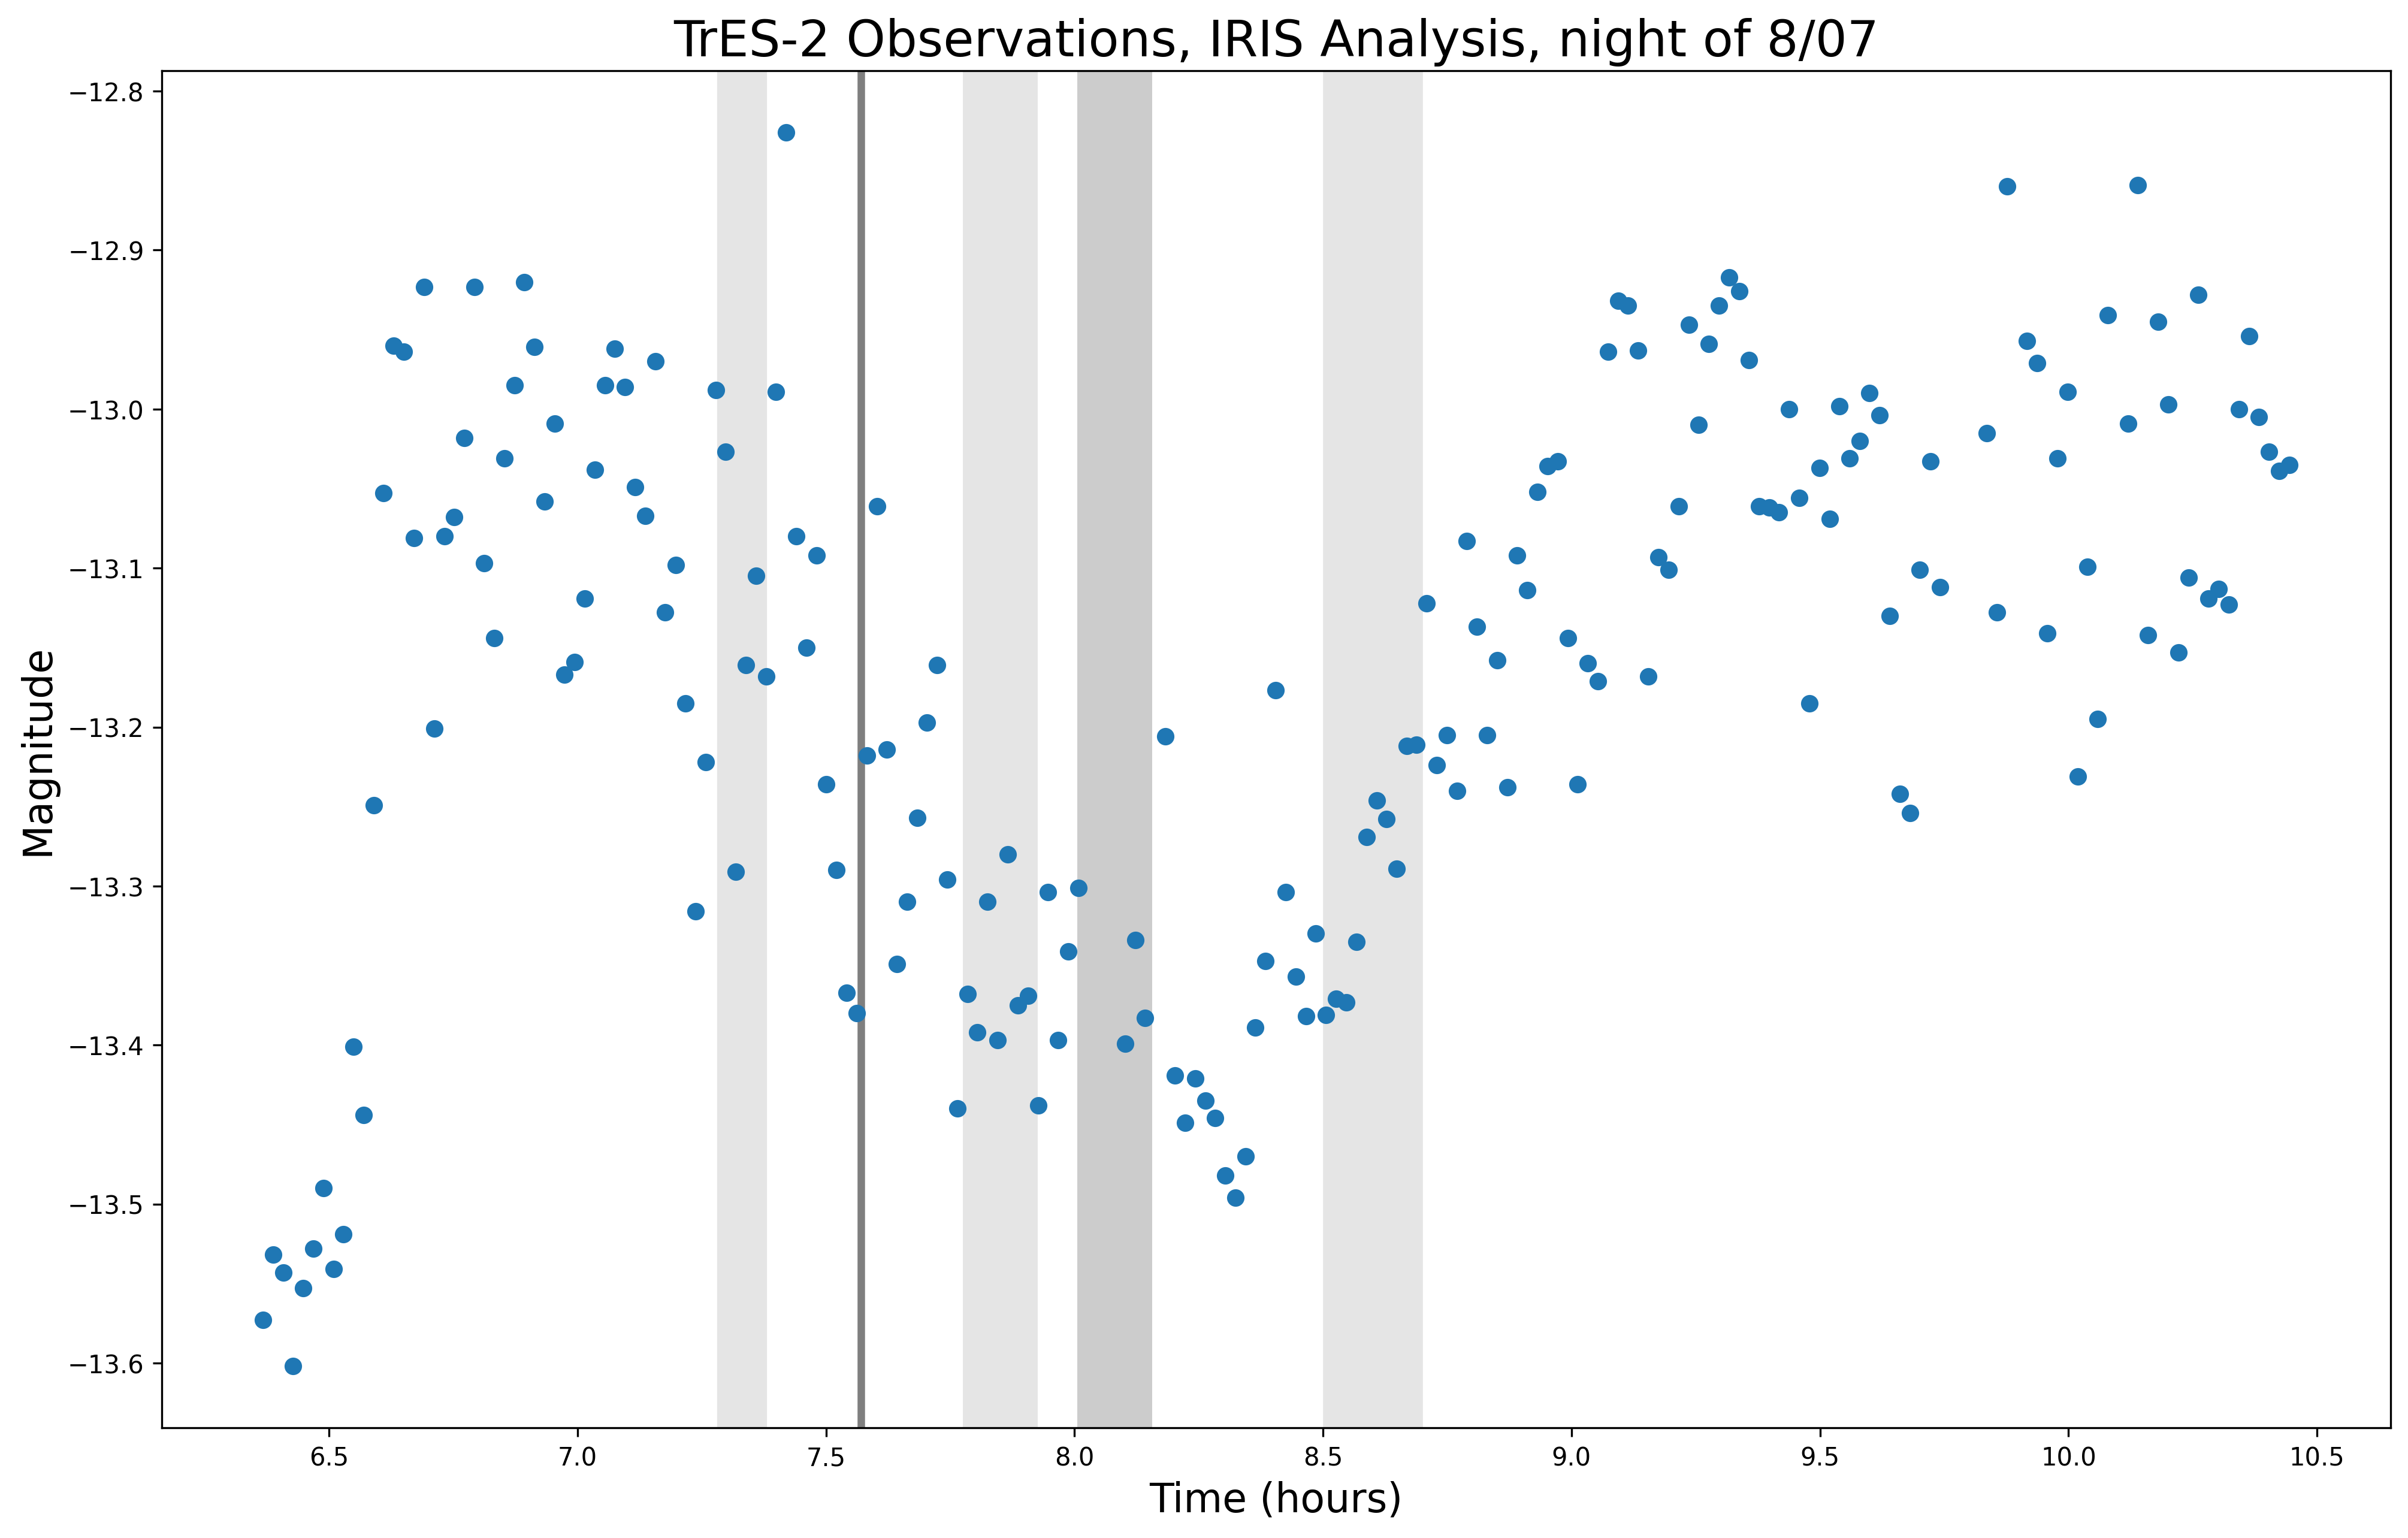

In [67]:
plt.figure(figsize=(16,10),dpi=300)

#You can use these to plot indicators. You could also use the method plotRefLinesForSource that I defined above, 
# but in this specific case that I last used this code I actually took the observations on the wrong day, so they 
# wouldn't have showed up anyway
plt.axvline(8.6,lw=40,c='k',alpha=0.1)
plt.axvline(8.08,lw=30,c='k',alpha=0.2)
plt.axvline(7.85,lw=30,c='k',alpha=0.1)
plt.axvline(7.33,lw=20,c='k',alpha=0.1)
plt.axvline(7.57,lw=3,c='k',alpha=0.5)

plt.plot(hours,target,'o')
plt.title("TrES-2 Observations, IRIS Analysis, night of 8/07",fontsize=20)
plt.ylabel("Magnitude",fontsize=16)
plt.xlabel("Time (hours)",fontsize=16)
plt.show()